# Analyze Distribution of Visual Wake Word Classes

In [1]:
# Analysts: Luke Berndt and John Speed Meyers
# Date: September 10, 2020
# Note: This notebook is derived from work by Google Research on visual wake words. Luke and
# John Speed customized it to do further analysis for a potential paper on the limitations
# of the current visual wake words dataset and training process and proposed methods
# for at least partially overcoming these limitations.
# Analyses
# #1: Create eight graphs, one for each category size threshold (4) and one for category type (2),
# where each category's percentage (of total samples) is graphed via a vertical bar

## Install pandas

In [1]:
!pip3 install pandas

     |████████████████████████████████| 10.5MB 8.0MB/s eta 0:00:01
     |████████████████████████████████| 512kB 47.9MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


## Import statements

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import hashlib
import io
import json
import os
import contextlib2

import PIL.Image

import pandas as pd
import six
import tensorflow.compat.v1 as tf

import matplotlib.pyplot as plot

## Helper functions for analysis

In [18]:
def total_image_count(annotations_file):

  with tf.gfile.GFile(annotations_file, 'r') as fid:
    groundtruth_data = json.load(fid)
    images = groundtruth_data['images']
    print("Total images: {}".format(len(images)))


def create_visual_wakeword_annotations(annotations_file,
                                       small_object_area_threshold,
                                       foreground_classes_of_interest):
  """Generate visual wakewords annotations file.

  Loads COCO annotation json files to generate visualwakewords annotations file.

  Args:
    annotations_file: JSON file containing COCO bounding box annotations
    visualwakewords_annotations_file: path to output annotations file
    small_object_area_threshold: threshold on fraction of image area below which
      small object bounding boxes are filtered
    foreground_classes_of_interest: category from COCO dataset that is filtered by
      the visual wakewords dataset
  """

  # default object of interest is person
  images_with_class = 0
  images_without_class = 0
  foreground_classes_of_interest_id_list = []

  with tf.gfile.GFile(annotations_file, 'r') as fid:
    groundtruth_data = json.load(fid)
    images = groundtruth_data['images']
    # Create category index
    category_index = {}
    for category in groundtruth_data['categories']:
      if category['name'] in foreground_classes_of_interest:
        foreground_classes_of_interest_id_list.append(category['id'])
        category_index[category['id']] = category

    # Create annotations index, a map of image_id to it's annotations
    annotations_index = collections.defaultdict(
        lambda: collections.defaultdict(list))

    # structure is { "image_id": {"objects" : [list of the image annotations]}}
    for annotation in groundtruth_data['annotations']:
        annotations_index[annotation['image_id']]['objects'].append(annotation)
    missing_annotation_count = len(images) - len(annotations_index)

    # Create filtered annotations index
    annotations_index_filtered = {}
    for idx, image in enumerate(images):
        annotations = annotations_index[image['id']]
        annotations_filtered = _filter_annotations(
            annotations, image, small_object_area_threshold,
            foreground_classes_of_interest_id_list)
        annotations_index_filtered[image['id']] = annotations_filtered

        if annotations_filtered['label'] == 1:
            images_with_class += 1
        else:
            images_without_class += 1
    
    # TODO: Return number of images too
    return images_with_class, (images_with_class / len(images))


def _filter_annotations(annotations, image, small_object_area_threshold,
                        foreground_classes_of_interest_id_list):
  """Filters COCO annotations to visual wakewords annotations.

  Args:
    annotations: dicts with keys: {
      u'objects': [{u'id', u'image_id', u'category_id', u'segmentation',
                  u'area', u'bbox' : [x,y,width,height], u'iscrowd'}] } Notice
                    that bounding box coordinates in the official COCO dataset
                    are given as [x, y, width, height] tuples using absolute
                    coordinates where x, y represent the top-left (0-indexed)
                    corner.
    image: dict with keys: [u'license', u'file_name', u'coco_url', u'height',
      u'width', u'date_captured', u'flickr_url', u'id']
    small_object_area_threshold: threshold on fraction of image area below which
      small objects are filtered
    foreground_classes_of_interest_id_list: list of the categories of COCO dataset which visual
      wakewords filters

  Returns:
    annotations_filtered: dict with keys: {
      u'objects': [{"area", "bbox" : [x,y,width,height]}],
      u'label',
      }
  """

  objects = []
  image_area = image['height'] * image['width']

  for annotation in annotations['objects']:
    normalized_object_area = annotation['area'] / image_area
    category_id = int(annotation['category_id'])
    # Filter valid bounding boxes
    if category_id in foreground_classes_of_interest_id_list and \
        normalized_object_area > small_object_area_threshold:
      objects.append({
          u'area': annotation['area'],
          u'bbox': annotation['bbox'],
      })

  label = 1 if objects else 0

  return {
      'objects': objects,
      'label': label,
  }

def create_visual_wakeword_category_list(annotations_file):
    """Generate lists of super- and sub-categories.

    Create list of all categories used in visual wake word analysis

    Args:
      annotations_file: JSON file containing COCO bounding box annotations
      
    Returns:
      (list1, list2)
        list1: All super-categories used for visual wake word models
        list2: All sub-categories used for visual wake word models
    """
    
    # Store supercategories and subcategories
    super_categories, sub_categories = [], []

    with tf.gfile.GFile(annotations_file, 'r') as fid:
        
        groundtruth_data = json.load(fid)
        
        # Loop thru all types of categories
        for entry in groundtruth_data['categories']:
            
            # Extract novel supercategories
            if entry['supercategory'] not in super_categories:
                super_categories.append(entry['supercategory'])
                
            # Extract subcategories    
            sub_categories.append(entry['name'])
            
    return super_categories, sub_categories

def create_sub2super_category_dict(annotations_file):
    """Generate dict mapping of sub to super categories.

    This mapping enables the create_analytical_dataframe function
    to have a dict of sub- to super-categories that then
    makes it possible to make graphs that are really aggregations
    of the sub-categories.

    Args:
      annotations_file: JSON file containing COCO bounding box annotations
      
    Returns:
      (dict) keys are sub-categories and values are super-category
    """
    
    # Empty dictionary to store mappings of sub-category to super-category
    sub2super_dict = {}

    with tf.gfile.GFile(annotations_file, 'r') as fid:
        
        groundtruth_data = json.load(fid)
        
        # Loop thru all types of categories
        for entry in groundtruth_data['categories']:
            
            # Key is sub-category, value is supercategory
            sub2super_dict[entry['name']] = entry['supercategory'] 
            
    return sub2super_dict

def create_analytical_dataframe(category_list, annotations_file):
    """Generate pandas dataframe to store all results needed for graphs
    
    Luke Berndt and John Speed Meyers wanted to analyze the categories present
    in the visual wake word dataset and determine at different threshold levels
    what percentage of the images contain each category.
    
    Args:
      category_list: pandas dataframe of categories to be analyzed
    
    """
    rows = []
    for category in category_list:
        category_results = []
        for threshold in [.005, .01, .05, .1, .25, .5]:
            image_count, fraction = create_visual_wakeword_annotations(train_annotations_file,
                                                        threshold,
                                                        category)
            rows.append([category, threshold, image_count, fraction])
    
    # Convert list of lists to dataframe
    df = pd.DataFrame(rows,
                      columns=['category', 'threshold', 'image_count', 'fraction'])
    
    # Instantiate mapping of sub to super categories
    sub2super_dict = create_sub2super_category_dict(annotations_file)
    
    # TODO: Create function that creates new column with super categories
    # for each row
    df['supercategory'] = df.apply(lambda row: sub2super_dict[row['category']], axis=1)
    
    return df

def convert_dataframe_to_graphs(df, category="category", y="fraction"):
    """Output vertical bar graphs by threshold.
    
    Output one graph per threshold. Each x axis is the categories
    present in the categories variable. The y axis is the fraction.
    
    TODO: If supercategory is specified, do call to separate aggregation
    function
    
    Args:
      df - A dataframe output by create_analytical_dataframe
      category - Whether to use category (or supercategory)
      y - A string indicating the variable to use on the axis
    
    """
    # Loop thru each unique threshold value present in the dataframe
    for threshold in df.threshold.unique():

        # Filter dataframe to contain only values of particular threshold
        # and sort in descending order
        df_filtered = df[df.threshold == threshold].sort_values(by=y, ascending=False)
        
        df_filtered.plot.bar(x=category, y=y,
                             rot=70, # Rotate x-axis labels
                             title="Fraction or count of images at {} threshold".format(threshold), # Graph title
                             figsize=(20,5), # Plot size
                             legend=False) # Turn legend off
        plot.xticks(fontsize=11) # Size of category labels

    plot.show(block=True)


In [4]:
df = create_analytical_dataframe(['car'], train_annotations_file)
print(df)

NameError: name 'train_annotations_file' is not defined

## Prepare Dataset for Analysis

In [13]:
# Create dataset paths
coco_dir = "/tf/dataset"
train_annotations_file = os.path.join(coco_dir, 'coco_dataset', 'annotations',
                                        'instances_train2014.json')
val_annotations_file = os.path.join(coco_dir, 'coco_dataset', 'annotations',
                                        'instances_val2014.json')


In [19]:
total_image_count(train_annotations_file)

Total images: 82783


In [6]:
# Create categories for later analysis
super_categories, sub_categories = create_visual_wakeword_category_list(train_annotations_file)

In [11]:
# Build dataset for use in graphs below
df = create_analytical_dataframe(sub_categories, train_annotations_file)

KeyboardInterrupt: 

In [10]:
is_category =  df['category']=='person'
df_category = df[is_category]
print(df_category)
print(df.size)

  category  threshold  image_count  fraction supercategory
0   person      0.005        39926  0.482297        person
1   person      0.010        37390  0.451663        person
2   person      0.050        26476  0.319824        person
3   person      0.100        18085  0.218463        person
4   person      0.250         6192  0.074798        person
5   person      0.500         1119  0.013517        person
2400


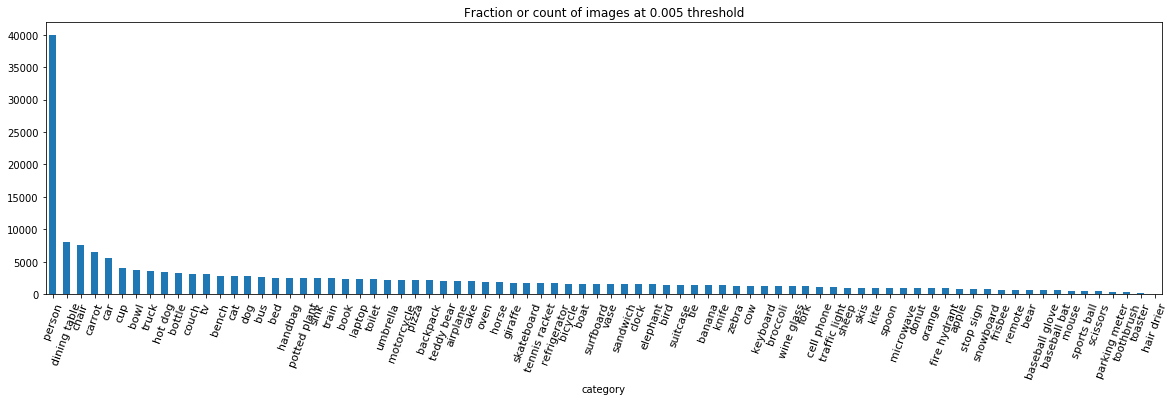

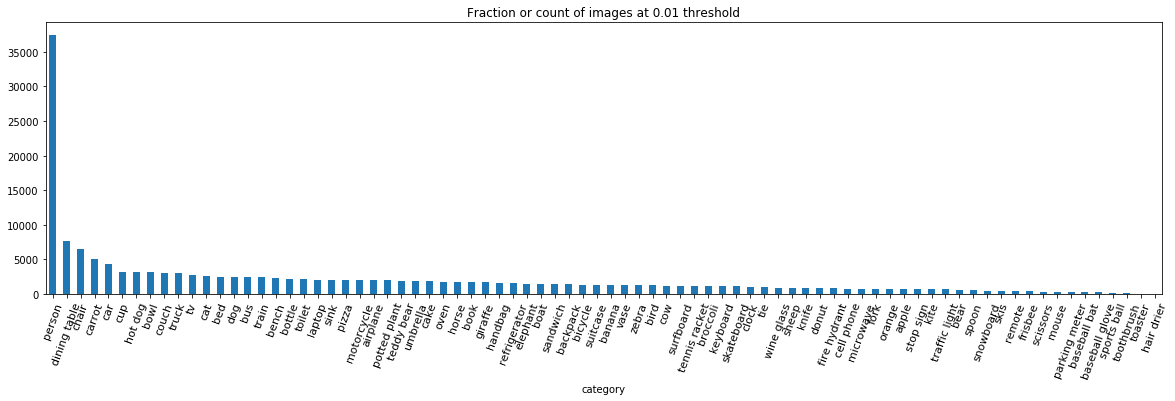

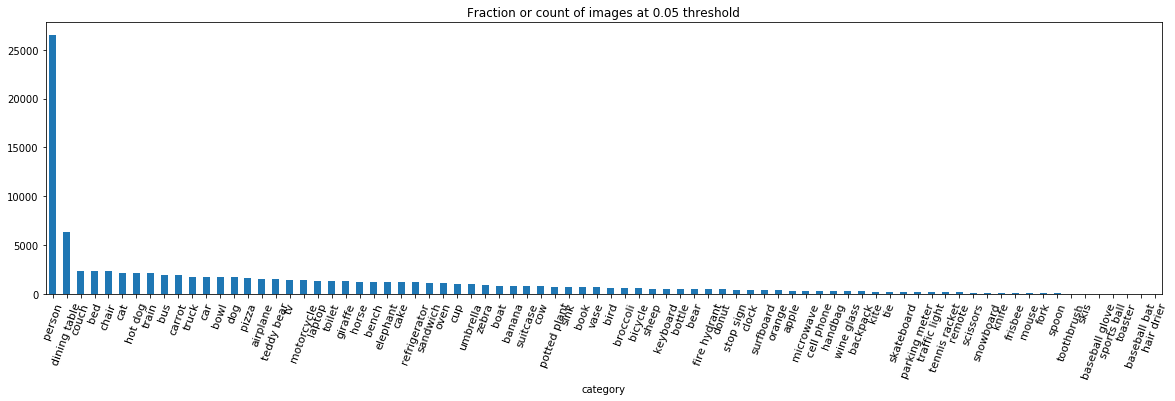

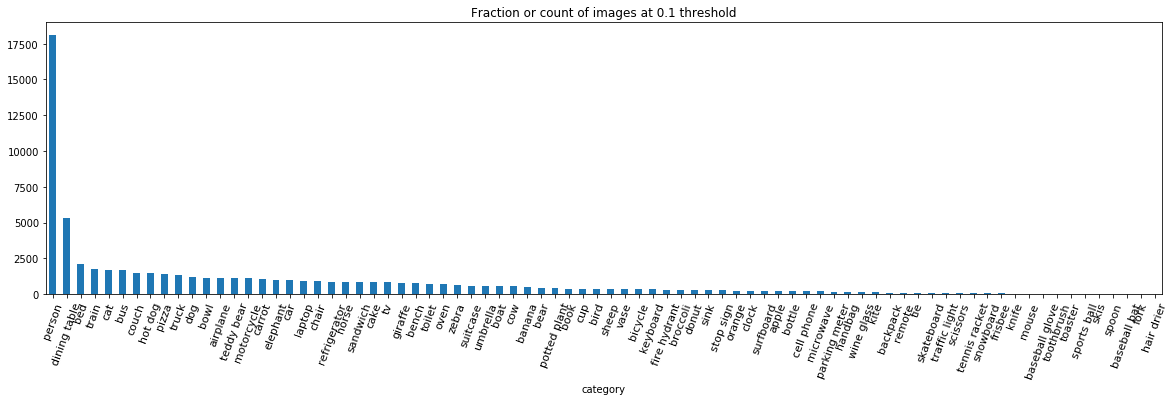

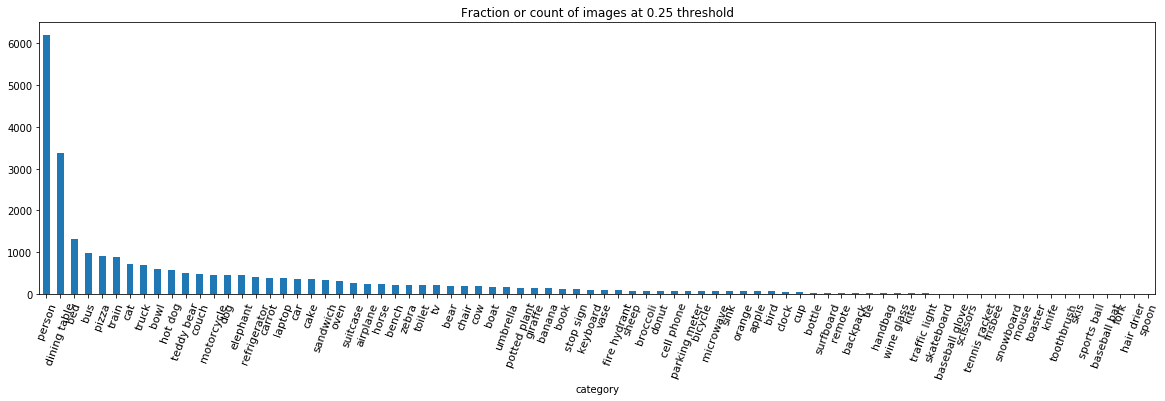

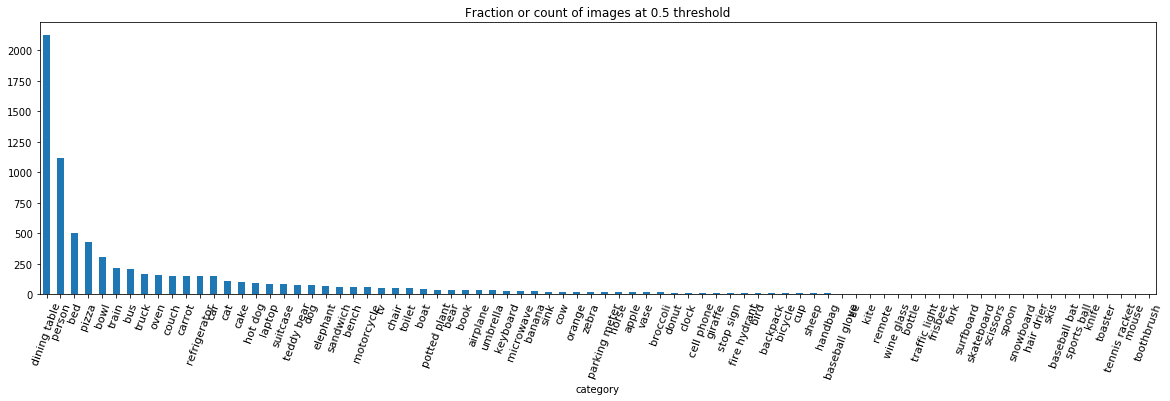

In [84]:
# TODO: This graph making capability doesn't work for the 
# super categories yet.
convert_dataframe_to_graphs(df, y="image_count")